<a href="https://colab.research.google.com/github/sahandv/science_science/blob/master/FastText_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FASTTEXT CLUSTERING



## Initialize

In [1]:
import os
print(os.environ['CONDA_DEFAULT_ENV'])

tf-n


Local OR Colab ?

In [2]:
# datapath = '/mnt/6016589416586D52/Users/z5204044/GoogleDrive/GoogleDrive/Data/' # Local
datapath = '/mnt/16A4A9BCA4A99EAD/GoogleDrive/Data/' # Local
# datapath = 'drive/My Drive/Data/' # Remote

### Clone Project Git Repo

In [ ]:
!rm -rf 'science_science'
username = "sahandv"#@param {type:"string"}
# password = ""#@param {type:"string"} 

!git clone https://github.com/$username/science_science.git
!ls

### Mount Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

### Install requirements

In [ ]:
!pip install -r 'science_science/requirements.txt'

In [ ]:
! pip install gensim==3.8.1

### Import Libs

In [3]:
import sys
import time
import gc
import collections
import json
import re
import os
import pprint
from random import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering, KMeans, SpectralClustering, AffinityPropagation
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from yellowbrick.cluster import KElbowVisualizer
import scipy.cluster.hierarchy as sch
from scipy import spatial,sparse,sign
from sklearn.feature_extraction.text import TfidfTransformer , TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn import preprocessing
from bokeh.io import push_notebook, show, output_notebook, output_file
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, LabelSet
from gensim.models import FastText as fasttext_gensim
from gensim.test.utils import get_tmpfile

import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
stop_words = set(stopwords.words("english"))
tqdm.pandas()

# from science_science.sciosci.assets import text_assets as kw
# from science_science.sciosci.assets import generic_assets as sci
# from science_science.sciosci.assets import advanced_assets as aa

from sciosci.assets import text_assets as kw
from sciosci.assets import generic_assets as sci
from sciosci.assets import advanced_assets as aa

[nltk_data] Downloading package stopwords to /home/sahand/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/sahand/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/sahand/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/home/sahand/anaconda3/envs/tf-n/lib/python3.8/site-packages/tqdm/std.py:670: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


## Load and Prepare Embeddings

#### Option A -  Load Corpus Vector Data

In [ ]:
file_address = datapath+'Corpus/improved_copyr_lemmatized_stopword_removed_thesaurus/FastText vector 1990-2018.json'
with open(file_address) as f:
    vectors = json.loads(f.read())

#### Option B - Load Document Vectors and Main Data

In [ ]:
#@markdown Usually it is not required to alter these years.
year_from = 1990#@param {type:"number"}
year_to = 2019#@param {type:"number"}
#@markdown File address for main WoS file:
file_address = datapath+'/Relevant Results _ DOI duplication - scopus keywords - document types - 31 july.csv'#@param {type:"string"} 
data_full = pd.read_csv(file_address)
data_full = data_full[data_full['PY'].astype('int')>year_from-1]
data_full = data_full[data_full['PY'].astype('int')<year_to]
data_full = data_full[pd.notnull(data_full['AB'])]
doc_titles = data_full['TI'].str.lower().values
doc_sources = data_full['SO'].str.lower().values
doc_research_topic = data_full['SC'].str.lower().values
doc_wos_topic = data_full['WC'].str.lower().values
doc_keywords = data_full['DE'].str.lower().values
# doc_keywords = data_full['ID'].str.lower().values
doc_year = data_full['PY'].astype('int').values
doc_index = data_full.index
doc_meta = data_full[['TI','AB','PY','Z9','U1','SO','JI','DE','ID','WC','SC']]

#@markdown Z9: Total Times Cited Count * U1: Usage Count (Last 180 Days) * 
#@markdown SO: Publication Name * JI: Source Abbreviation * 
#@markdown DE: Author Keywords * ID: Keywords Plus * 
#@markdown WC: Web of Science Categories * SC: Research Areas

In [ ]:
#@markdown File address for doc vectors:
file_address =  datapath+"/corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/1990-2018 FastText doc vectors - SIF - full.csv"#@param {type:"string"} 
doc_vectors = pd.read_csv(file_address)
doc_vectors = doc_vectors.values
doc_vectors

In [ ]:
#@markdown Make sure all dimensions match:
print(doc_sources.shape,doc_year.shape,doc_titles.shape,data_full.shape,doc_vectors.shape)

#### Option C - Load (author/LDA) Term Vector Data

In [ ]:
dim = '15'
dim_comment = ''
period = '1990-2018'
subfolder = ''
file_address = datapath+'Author keywords - 29 Oct 2019/vectors/'+dim+'D'+dim_comment+'/'+subfolder+'FastText vector '+period+'.json'
with open(file_address) as f:
    vectors = json.loads(f.read())

#### Option D - Load Abstract with n-grams

In [5]:
#@markdown Don't forget to set the "year_to" to a year higher than intended!
# year_from = 2017#@param {type:"number"}
# year_to = 2020#@param {type:"number"}
period = ''#str(year_from)+'-'+str(year_to-1)
#@markdown File address for main WoS file:
# file_address = datapath+'Corpus/AI 4k/copyr_deflem_stopword_removed_thesaurus May 28/by period/n-gram by 6 repetition keywords/'+period+' abstract_title'
file_address = datapath+'Corpus/AI 4k/copyr_deflem_stopword_removed_thesaurus May 28/1990-2019/1990-2019 n-gram by 6 repetition keywords'
abstracts = pd.read_csv(file_address,names=['abstract'])
print('period:',period,'\n',abstracts)

period:  
                                                abstract
0     generalised ARC_CONSISTENCY alldifferent const...
1     performing WORD_SENSE_DISAMBIGUATION border un...
2     nearest prototype classification NOISY_DATA ne...
3     generalized KNOWLEDGE_REPRESENTATION system co...
4     real time identification control DYNAMIC_SYSTE...
...                                                 ...
3954  asynchronous forward bounding distributed cop ...
3955  wikipedia based SEMANTIC_INTERPRETATION NATURA...
3956  exploiting single cycle symmetry continuous co...
3957  behavior bounding efficient method high level ...
3958  policy iteration decentralized control MARKOV_...

[3959 rows x 1 columns]


Load abstract vectors (for doc clustering)

In [7]:
#@markdown File path for doc vectors:
file_address =  datapath+"Corpus/AI 4k/embeddings/"#@param {type:"string"} 
doc_vectors = pd.read_csv(file_address+period+'Doc2Vec patent_wos_ai corpus')
year_vectors = doc_vectors.values
print(year_vectors.shape)

(3959, 100)


#### Option E - Load Keywords

In [ ]:
#@markdown Don't forget to set the "year_to" to a year higher than intended!
year_from = 2017#@param {type:"number"}
year_to = 2019#@param {type:"number"}
period = str(year_from)+'-'+str(year_to-1)
file_address = datapath+'Corpus/copyr_lemmatized_stopword_removed_thesaurus/1900-2019 keywords'
keywords = pd.read_csv(file_address,names=['keywords'])
file_address = datapath+'Corpus/copyr_lemmatized_stopword_removed_thesaurus/1900-2019 years'
years = pd.read_csv(file_address)
keywords['year'] = years['year']
keywords = keywords[(keywords['year']>=year_from) & (keywords['year']<year_to)]
print('period:',period,'\n',keywords)

Extract Keywords and Flatten

In [ ]:
keywords['keywords_sep'],keywords_flat = kw.tokenize_series_fast(keywords['keywords'],delimiter=';',flatten=True)

#### Option F - Benchmark Data

In [ ]:
file_address =  datapath+"embedding_benchmark/kpris_data.csv"
data = pd.read_csv(file_address)
abstracts = data[['abstract']]
file_address = datapath+'embedding_benchmark/clean/Document Embedding/finetuned_embeddings_50D.csv'
doc_vectors = pd.read_csv(file_address)

task_1 = data[(data['target']=='car') | (data['target']=='camera')]
task_2 = data[(data['target']=='memory') | (data['target']=='cpu')]

period = 'all'
# columns = [1,3,4,5,7,9,10,11,13,14]
year_vectors = doc_vectors.values
# vector_low_dim = doc_vectors.values.T[columns]
# year_vectors = vector_low_dim.T
year_vectors = year_vectors[task_1.index]
print(year_vectors.shape)

In [ ]:
year_vectors = TSNE(n_components=2, n_iter=500, verbose=2).fit_transform(year_vectors)
print("\nComputed t-SNE", vector_low_dim.shape)

#### Word Embedding
Load embedding model

In [ ]:
!ls 'drive/My Drive/Data/FastText Models/50D May 16/fasttext-scopus-300k_docs-gensim 50D.model'
gensim_model_address = datapath+'FastText Models/50D May 16/fasttext-scopus-300k_docs-gensim 50D.model'
FT_model = fasttext_gensim.load(gensim_model_address)

##### Get Embeddings

###### Use duplicated words to take into the account the weight of words

In [ ]:
# Iterate docs and flatten words to a list
word_freq = pd.DataFrame(pd.DataFrame([word for doc in abstracts['abstract'].values.tolist() for word in doc.split()],columns=['terms']).terms.value_counts()).reset_index()
word_freq.columns=['term','freq']
word_filter = word_freq[word_freq['freq']>8]
words = [word for doc in tqdm(abstracts['abstract'].values.tolist(),total=len(abstracts['abstract'].values.tolist())) for word in doc.split() if word in word_filter['term'].values.tolist()]
print('\n',len(words))

In [ ]:
# make an embedding list
word_vectors = []
for item in tqdm(words):
    phrase = item.replace("_", " ")
    phrase = phrase.lower().strip()
    phrase = phrase.split()
    gram_vecs = []
    for gram in phrase:
        gram_vecs.append(FT_model.wv[gram])
    phrase_vec = np.array(gram_vecs).mean(axis=0)
    word_vectors.append(phrase_vec)
vector_low_dim = word_vectors
print('\n',len(word_vectors))

###### Use unique words to ignore duplicated keywords and ignore the weights of words

In [ ]:
# Iterate docs and flatten words to a list
word_freq = pd.DataFrame(pd.DataFrame([word for doc in abstracts['abstract'].values.tolist() for word in doc.split()],columns=['terms']).terms.value_counts()).reset_index()
word_freq.columns=['term','freq']
word_freq['term'] = word_freq['term'].str.lower()
word_freq['term'] = word_freq['term'].progress_apply(lambda x: x if len(x)>1 else np.nan)
word_freq = word_freq[pd.notnull(word_freq['term'])]
word_filter = word_freq[word_freq['freq']>8]
words = word_filter.term.values.tolist()

In [ ]:
# make an embedding list
word_vectors = []
for item in tqdm(words):
    phrase = item.replace("_", " ")
    phrase = phrase.lower().strip()
    phrase = phrase.split()
    gram_vecs = []
    for gram in phrase:
        gram_vecs.append(FT_model.wv[gram])
    phrase_vec = np.array(gram_vecs).mean(axis=0)
    word_vectors.append(phrase_vec)
vector_low_dim = word_vectors
print('\n',len(word_vectors))

In [ ]:
terms_flat = words

###### For keyword embedding (Option E)

In [ ]:
# Iterate docs and flatten words to a list
word_freq = pd.DataFrame(keywords_flat.tokens.value_counts()).reset_index()
word_freq.columns=['term','freq']
word_filter = word_freq[word_freq['freq']>5]
words = word_filter.term.values.tolist()

In [ ]:
# make an embedding list
word_vectors = []
for item in tqdm(words):
    phrase = item.replace("_", " ")
    phrase = phrase.lower().strip()
    phrase = phrase.split()
    gram_vecs = []
    for gram in phrase:
        gram_vecs.append(FT_model.wv[gram])
    phrase_vec = np.array(gram_vecs).mean(axis=0)
    word_vectors.append(phrase_vec)
vector_low_dim = word_vectors
print('\n',len(word_vectors))

In [ ]:
terms_flat = words

### Pre processing (For word clustering)

#### (If Option C - and A?) Flatten vectors and make a generic dictionary for all years-words

In [ ]:
vectors_flat = []
terms_flat = []

for term in tqdm(vectors.keys(),total=len(vectors.keys())):
      terms_flat.append(term)
      vectors_flat.append(np.array([float(i) for i in vectors[term].replace('[','').replace(']','').replace(', ',' ').split()]))


print('\nYou have ',len(vectors_flat),'unique vectors and terms')
if len(vectors_flat)!=len(terms_flat):
    sys.exit('Term/Vector length mismatch. Please the terms_flat and vectors_flat variables.')

vectors_flat = np.array(vectors_flat)

#### Normalize - Optional.  
Define row_sums first

In [ ]:
vectors_flat_sums = vector_low_dim.sum(axis=1)
vectors_flat_norm = vector_low_dim / row_sums[:, np.newaxis]
vectors_flat_norm.shape

OR use this 

In [ ]:
x = np.array(vector_low_dim)
min_max_scaler = preprocessing.MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
vectors_flat_norm = list(x_scaled)
x_scaled.shape

#### Reduce Dimensionality for 15D

In [ ]:
sub_dim = ''
vector_low_dim = vectors_flat.copy()

In [ ]:
sub_dim = '10 dim/'
tmp_df = pd.DataFrame(vectors_flat)
columns = [1,3,4,5,7,9,10,11,13,14]
vector_low_dim = tmp_df[columns].values
vector_low_dim.shape

#### (If Option A) Load year period corpora and make year based vectors

In [ ]:
period = '1990-2018'
file_address = datapath+'corpus/improved_copyr_lemmatized_stopword_removed_thesaurus/'+period+' corpus abstract-title'
corpus = pd.read_csv(file_address,names=['abstracts'])
corpus.head(2)

In [ ]:
period_vectors = []
period_terms = []

period_article_vectors = []
period_article_terms = []
period_article_indices = []

for idx,row in tqdm(corpus.iterrows(),total = corpus.shape[0]):
    article_terms = []
    article_vectors = []
    for term in row['abstracts'].split():
        period_vectors.append(vectors_flat[terms_flat.index(term)])
        article_vectors.append(vectors_flat[terms_flat.index(term)])
        period_terms.append(term)
        article_terms.append(term)
    period_article_vectors.append(article_vectors)
    period_article_terms.append(article_terms)
    period_article_indices.append(idx)
period_vectors = np.array(period_vectors)

In [ ]:
len(period_article_vectors)

## Visualize Embeddings (vectors)

#### Get a list of terms to embed

In [ ]:
demo_terms = pd.read_csv(datapath+'LDA/selected_demo_words',names=['terms']).T.values.tolist()[0] # this is 2016 words probably
demo_vectors = np.array([np.array([float(i) for i in vectors[term].replace('[','').replace(']','').replace(', ',' ').split()]) for term in demo_terms])

In [ ]:
demo_vectors.shape

#### Manually reduce dims

In [ ]:
vector_low_dim = []
dim_1 = 0
dim_2 = 1
for row in tqdm(vectors_flat,total=vectors_flat.shape[0]):
    vector_low_dim.append([row[dim_1],row[dim_2]])
vector_low_dim = np.array(vector_low_dim)
vector_low_dim.shape

#### PCA reduce dims

Explore component variances

In [ ]:
pca = PCA()
pca.fit(vectors_flat)
pca.explained_variance_ratio_

Reduce

In [ ]:
pca = PCA(2)
pca.fit(vectors_flat)
#pca.n_components_
vector_low_dim_pca = pca.transform(vectors_flat)
vector_low_dim_pca.shape

#### Use TSNE for reduce dims

In [ ]:
vector_low_dim = TSNE(n_components=2, n_iter=250, verbose=2).fit_transform(vectors_flat)
print("\nComputed t-SNE", vector_low_dim.shape)

#### Visualize dims

In [ ]:
vector_low_dim_df = pd.DataFrame(columns=['x', 'y', 'word'])
vector_low_dim_df['x'], vector_low_dim_df['y'], vector_low_dim_df['word'] = vector_low_dim[:,0], vector_low_dim[:,1], terms_flat
vector_low_dim_df.head(2)

#### Plot

##### Selective demo terms

In [ ]:
vector_low_dim_df = vector_low_dim_df[vector_low_dim_df['word'].isin(demo_terms)]
vector_low_dim_df.shape

##### Selective by top 1 percent keywords

In [ ]:
word_filter = []
top_one_percent_keywords = pd.read_csv(datapath+'LDA/'+period+' top_99-percentile_keywords_terms.csv')
for indx,row in tqdm(top_one_percent_keywords.iterrows(),total=top_one_percent_keywords.shape[0]):
    for word in row:
        if word not in word_filter:
            word_filter.append(word)

vector_low_dim_df = vector_low_dim_df[vector_low_dim_df['word'].isin(word_filter)]
vector_low_dim_df.shape

##### Continue plotting

In [ ]:
source = ColumnDataSource(ColumnDataSource.from_df(vector_low_dim_df))
labels = LabelSet(x="x", y="y", text="word", y_offset=8,
                  text_font_size="8pt", text_color="#555555",
                  source=source, text_align='center')
plot = figure(plot_width=1900, plot_height=1000)
plot.circle("x", "y", size=12, source=source, line_color="black", fill_alpha=0.8)
output_file("drive/My Drive/Data/FastText term clusters/bokeh cluster visualization/15D manual top 1 percent/bokeh "+dim+"D selective - Manual 0 "+str(dim_2)+".html")
plot.add_layout(labels)
show(plot, notebook_handle=True)

# Word Clustering 

### Simple Clustering

#### Find optimal cluster size: Elbow / Dendrogram method

The data shows that it is impossible to perform clustering on the vectors using k means.

In [ ]:
#@title Distortion should go down.
model = KMeans()
visualizer = KElbowVisualizer(model, k=(2,30))
visualizer.fit(vectors_flat)                                                    # Fit the data to the visualizer
visualizer.poof()

In [ ]:
#@title Dendrogram
dendrogram = aa.fancy_dendrogram(sch.linkage(vector_low_dim, method='ward'),
                                 truncate_mode='lastp',p=800,show_contracted=True,figsize=(15,9)) #single #average #ward

#### Init clustering

In [ ]:
pca = PCA(2)
pca.fit(vector_low_dim)
#pca.n_components_
vector_low_dim = pca.transform(vector_low_dim)
vector_low_dim[:,1].shape
reduce_dim = True

In [ ]:
reduce_dim = False

In [ ]:
n_clusters = 12
comment = ''
dim = '50'
dim_comment = ' May 28'
sub_dim = '' #'no repetition/'

#### Hierarchical Clustering

In [ ]:
model = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(vector_low_dim)
labels = model.labels_

clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
clusters_df.to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)

# model = AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='average').fit(vectors_flat)
# labels = model.labels_

# clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
# clusters_df.to_csv('drive/My Drive/Data/FastText term clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomarative cosine average '+period+' '+str(n_clusters)+comment+'.csv',index=False)

#### K-means Clustering

In [ ]:
model = KMeans(n_clusters=n_clusters, random_state=10).fit(vector_low_dim)
labels = model.labels_

clusters_df = pd.DataFrame({'terms':terms_flat,'clusters':labels})
clusters_df.to_csv(datapath+'FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'kmeans '+period+' '+str(n_clusters)+comment+'.csv',index=False)

#### Visualize cluster

Read saved clusters

In [ ]:
cluster_file_name = datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
cluster_file_name

In [ ]:
clusters_df = pd.read_csv(cluster_file_name+'.csv')
clusters_df = clusters_df[clusters_df['terms'].isin(terms_flat)]
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors

##### Visualize

In [ ]:
fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
for i, label in enumerate(terms_flat):
    ax.annotate(label, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name+'.jpg')

##### Visualize - reduced samples

Get important words

In [ ]:
whitelist = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    whitelist = whitelist + clusters_df['terms'][list(clusters_df.groupby('clusters').groups[idx])].head(30).values.tolist()

fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim_pca[:,0], vector_low_dim_pca[:,1],color = colors)
for i, label in enumerate(terms_flat):
    if label in whitelist:
        ax.annotate(label, (vector_low_dim_pca[i,0], vector_low_dim_pca[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name+' - reduced labels.jpg')

### Word Cluster Cloud

In [ ]:
# dim = '15'
# period = '2017-2019'
n_clusters = 4
# method = 'kmeans '
method = 'agglomerative ward '
comment = ''
# comment = ' visually_assessed'

Load corpus for the period

In [ ]:
path = datapath+'corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/'+period+' corpus abstract-title - with n-grams'
corpus = pd.read_csv(path,names=['abstract'])
path

Load cluster for the period

In [ ]:
path = datapath+'FastText term clusters/'+dim+'D/'+method+period+' '+str(n_clusters)+comment+'.csv'
clusters = pd.read_csv(path)
path

Mask the corpus terms by cluster terms

In [ ]:
cluster_corpora = []
for cluster_label in range(n_clusters):
    white_list = clusters[clusters['clusters']==cluster_label].terms.values.tolist()
    cluster_corpus = []
    for abstract in tqdm(corpus.abstract,total=corpus.abstract.shape[0]):
        tokenized_abstract = abstract.split()
        cluster_corpus.append(' '.join([token for token in tokenized_abstract if token in white_list]))
    cluster_corpora.append(cluster_corpus)

OR - Make cluster corpora based on the doc term corpus (Option D)

In [ ]:
cluster_corpora = []
for cluster_label in range(n_clusters):
    white_list = clusters_df[clusters_df['clusters']==cluster_label].terms.values.tolist()
    cluster_corpus = []
    for abstract in tqdm(abstracts.abstract.values.tolist(),total=abstracts.abstract.values.shape[0]):
        tokenized_abstract = abstract.split()
        cluster_corpus.append(' '.join([token for token in tokenized_abstract if token in white_list]))
    cluster_corpora.append(cluster_corpus)

Generate word cloud for each cluster

In [ ]:
for cluster_label in range(n_clusters):
    wordcloud = WordCloud(background_color='white',
                        stopwords=stop_words,
                        max_words=100,
                        max_font_size=50, 
                        width=800, height=400,
                        random_state=42).generate(str(cluster_corpora[cluster_label]))
    fig = plt.figure(1)
    plt.imshow(wordcloud,interpolation="bilinear")
    plt.axis('off')
    plt.title('Cluster '+str(cluster_label))
    plt.tight_layout(pad=0)
    plt.show()
    # fig.savefig('drive/My Drive/Data/FastText term clusters/'+dim+'D/wordcloud/'+period+' '+method+' cluster_'+str(cluster_label+1)+'.png', dpi=500)
    fig.savefig(datapath+'FastText doc word clusters 2020/'+dim+'D'+dim_comment+'/'+sub_dim+'wordcloud/'+period+' cluster_'+str(cluster_label+1)+'.png', dpi=500)

## Word Cluster Center Calculator

### Read clusters

In [ ]:
# dim = '50'
# dim_comment = ' w1'
# n_clusters = 17
# sub_dim = 'no repetition/'
# comment = ''
# method = 'kmeans '
method = 'agglomerative ward '
cluster_file_name = datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+method+period+' '+str(n_clusters)+comment

clusters_df = pd.read_csv(cluster_file_name+'.csv')
clusters_df = clusters_df[clusters_df['terms'].isin(terms_flat)]
# color_palette = aa.color_palette_maker(n_clusters)
# colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
# clusters_df['colors'] = colors

In [ ]:
# Get cluster term frequencies
top_words = []
for cluster in tqdm(range(n_clusters)):
    top_words.append(', '.join(clusters_df[clusters_df['clusters']==cluster].groupby('terms').count()['clusters'].reset_index().sort_values(by='clusters', ascending=False).head(10)['terms'].values.tolist()))

top_words = pd.DataFrame(top_words)
top_words.to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'labels/'+method+period+' '+str(n_clusters),header=False)

### Find cluster centre

In [ ]:
cluster_centers = []
for cluster in tqdm(range(n_clusters),total=n_clusters):
    cluster_centers.append(np.array(vector_low_dim)[clusters_df[clusters_df['clusters']==cluster].index].mean(axis=0))
pd.DataFrame(cluster_centers).to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/cluster_centers - agglomerative ward '+period+' '+str(n_clusters)+comment)


In [ ]:
!ls 'drive/My Drive/Data/Word Clustering/50D May 28/centers/'

## Cluster Center Similarity Calculator

Load clusters

In [ ]:
sub_dim = ''#@param {type:"string"} 
dim = '50'#@param {type:"string"} 
comment = ''#@param {type:"string"} 
dim_comment = ' w1'

period_A = '2008-2010'#@param {type:"string"} 
n_clusters_A = 9#@param {type:"number"} 

period_B = '2017-2018'#@param {type:"string"} 
n_clusters_B = 17#@param {type:"number"} 

clusters_A = pd.read_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/cluster_centers - agglomerative ward '+period_A+' '+str(n_clusters_A)+comment,index_col=0)
clusters_B = pd.read_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/cluster_centers - agglomerative ward '+period_B+' '+str(n_clusters_B)+comment,index_col=0)


### Cosine similarity calculation from period A to period B with following format:


```
cluster_1,cluster_2_0,similarity_0,cluster_2_1,similarity_1,cluster_2_2,similarity_2,cluster_2_3,similarity_3,cluster_2_4,similarity_4
0,0,0.8512495748329945,1,0.9026553867095742,2,0.9891524888487816,3,0.8417661013507162,4,0.9009857248135538
1,0,0.945069537373128,1,0.9293686285273433,2,0.9089606504506658,3,0.9068286759630998,4,0.8822693454546485
2,0,0.8889985179190727,1,0.6474221422202824,2,0.717458586171551,3,0.7027810005644912,4,0.5373087435431511



```



In [ ]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        distance_tmp = spatial.distance.cosine(vector_A.values, vector_B.values)
        similarity_tmp = 1 - distance_tmp

        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+'.csv',index=False)

### Euclidean similarity calculation

In [ ]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        # distance_tmp = spatial.distance.euclidean(vector_A.values, vector_B.values) # automatic calculation
        distance_tmp = np.linalg.norm(vector_A.values-vector_B.values) # manual calculation
        similarity_tmp = distance_tmp
        # similarity_tmp = 1 - distance_tmp


        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv(datapath+'FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+' - euclidean.csv',index=False)

## Term Cluster and Term Score Cluster Table Maker

Label maker based on centrality

In [ ]:
# dim = '50'
# period = '2017-2018'
# dim_comment = ' w1'
# n_clusters = 17
sub_dim = ''
comment = ''
# method = 'kmeans '
method = 'agglomerative ward '
cluster_file_name = datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+method+period+' '+str(n_clusters)+comment

clusters_df = pd.read_csv(cluster_file_name+'.csv')
clusters_df = clusters_df[clusters_df['terms'].isin(terms_flat)]

# Read cluster center
centers_file_name = datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/cluster_centers - '+method+period+' '+str(n_clusters)+comment
cluster_centers = pd.read_csv(centers_file_name,index_col=0)

# Calculate centroid words for n-gram handling
def embed(word,model):
    phrase=word.split()
    gram_vecs = []
    for gram in phrase:
        gram_vecs.append(model.wv[gram])
    return np.array(gram_vecs).mean(axis=0)

top_words = []
top_scores = []
for cluster_n in range(n_clusters-1):
    cluster_center = cluster_centers.iloc[cluster_n].values
    cluster_terms = clusters_df[clusters_df['clusters']==cluster_n].copy()
    
    x = [embed(word,FT_model) for word in cluster_terms['terms'].values.tolist()]
    if(reduce_dim==True):
        pca.fit(x)
        cluster_terms['vectors'] = pca.transform(x).tolist()
    else:
        cluster_terms['vectors'] = x

    cluster_terms['similarity'] = [1-spatial.distance.cosine(vector, cluster_center) for vector in np.array(cluster_terms['vectors'])]
    cluster_terms = cluster_terms.sort_values(by=['similarity'],ascending=False)
    top_words.append(cluster_terms.head(100)['terms'].values.tolist())
    top_scores.append(cluster_terms.head(100)['similarity'].values.tolist())
pd.DataFrame(top_words).to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'labels/terms '+period+' '+str(n_clusters)+comment,index=False,header=False)
pd.DataFrame(top_scores).to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'labels/similarity '+period+' '+str(n_clusters)+comment,index=False,header=False)

From file

In [ ]:
# sub_dim = '10 dim/'
# dim_comment = ' 3pcnt'
# dim = '15'
# period = '1990-2018'
# n_clusters = 8
comment = ''
corpus = pd.read_csv(datapath+'Author keywords - 29 Oct 2019/'+period+' keyword frequency',names=['keyword','frequency'])

cluster_file_name = datapath+'FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
clusters = pd.read_csv(cluster_file_name+'.csv')
term_table = clusters.groupby('clusters').groups
# term_table_df = pd.DataFrame([list(clusters['terms'][term_table[x]]) for x in term_table]).T.fillna('')
# score_table_df = [list(corpus[corpus['keyword']==clusters['terms'][term_table[x]]]['frequency']) for x in term_table]

# groups.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment,index=False)

term_table_df = []
score_table_df = []
for cluster_items in term_table:
    cluster_terms = list(clusters['terms'][term_table[cluster_items]])
    cluster_scores = [corpus[corpus['keyword']==x]['frequency'].values[0] for x in cluster_terms]
    score_table_df.append(cluster_scores)
    term_table_df.append(cluster_terms)
comment = ' - term_cluster'
term_table_df = pd.DataFrame(term_table_df).T.to_csv(datapath+'FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
score_table_df = pd.DataFrame(score_table_df).T.to_csv(datapath+'FastText authkeyword clusters - 29 Oct 2019/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)


From doc words (Option D )

In [ ]:
comment = ''
corpus = word_freq.copy()
term_table = clusters_df.groupby('clusters').groups
# term_table_df = pd.DataFrame([list(clusters['terms'][term_table[x]]) for x in term_table]).T.fillna('')
# score_table_df = [list(corpus[corpus['keyword']==clusters['terms'][term_table[x]]]['frequency']) for x in term_table]

# groups.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment,index=False)

term_table_df = []
score_table_df = []
for cluster_items in term_table:
    cluster_terms = list(clusters_df['terms'][term_table[cluster_items]])
    cluster_scores = [corpus[corpus['term']==x]['freq'].values[0] for x in cluster_terms]
    score_table_df.append(cluster_scores)
    term_table_df.append(cluster_terms)

comment = ' - term_cluster'
term_table_df = pd.DataFrame(term_table_df).T.to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
score_table_df = pd.DataFrame(score_table_df).T.to_csv(datapath+'Word Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+period+' '+str(n_clusters)+comment+'.csv',index=False)


# Document Clustering

## Simple averaging

#### Calculate document vectors

In [ ]:
article_vectors = []
for idx,article in tqdm(enumerate(period_article_vectors),total=len(period_article_vectors)):
    article_vectors.append(np.array(pd.DataFrame(article).mean().values.tolist()))

In [ ]:
article_vectors_np = np.array(article_vectors)
article_vectors_np.shape

#### Save doc vectors to disk

In [ ]:
article_vectors_df = pd.DataFrame(article_vectors_np)
article_vectors_df['article'] = period_article_indices
article_vectors_df.to_csv(datapath+'FastText doc vectors/'+'FastText doc vectors '+period+'.csv')

#### Find out the N-clusters

In [21]:
#@title K-Means elbow (Distortion should go down.)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(3,100))
visualizer.fit(year_vectors)                                                    # Fit the data to the visualizer
visualizer.poof()  

In [20]:
#@title K-Means silhouette score 

silhouette_avg_all = []
cluster_range =list(range(2,50,2))

print("Gridsearching the cluster ranges . . . ")
for n_clusters in tqdm(cluster_range,total=len(cluster_range)):
    # clustering = AgglomerativeClustering(n_clusters=n_clusters,affinity='cosine',linkage='complete').fit(articles_vectors_filtered_np)
    clustering = KMeans(n_clusters=n_clusters, random_state=10).fit(year_vectors)
    # clustering = AffinityPropagation().fit(article_vectors_np)
    
    cluster_labels = clustering.labels_
    silhouette_avg = silhouette_score(year_vectors, cluster_labels)
    silhouette_avg_all.append(silhouette_avg)

fig = plt.figure()
plt.plot(silhouette_avg_all)
plt.show()

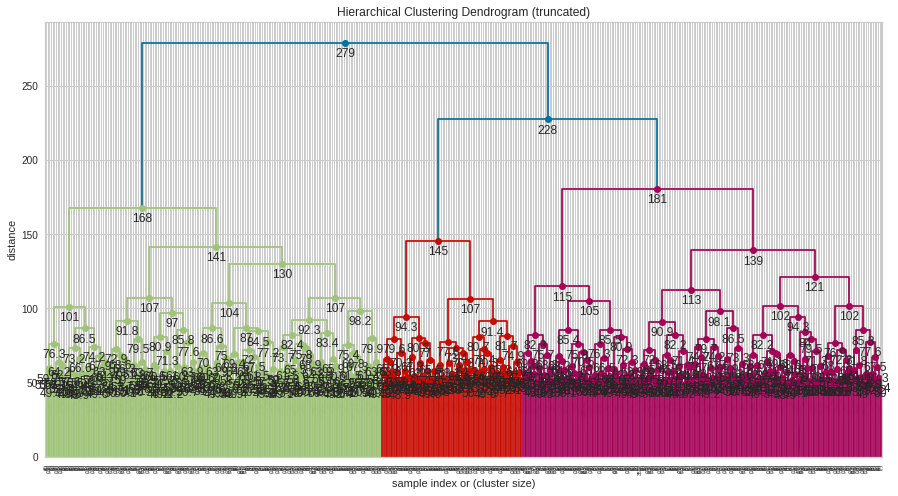

In [16]:
#@title Dendrogram 
dendrogram = aa.fancy_dendrogram(sch.linkage(year_vectors, method='ward'),
                                 truncate_mode='lastp',p=500,show_contracted=True,figsize=(15,8)) #single #average #ward

#### Cluster - simple kmeans

In [ ]:
n_clusters = 9

model = KMeans(n_clusters=n_clusters, random_state=10).fit(article_vectors_np)
labels = model.labels_

clusters_df = pd.DataFrame({'articles':period_article_indices,'clusters':labels})

clusters_df.to_csv(datapath+'FastText doc clusters/'+'FastText doc clusters kmeans '+period+' '+str(n_clusters)+'.csv',index=False)

## Weighted averaging / SIF

#### Prepare vectors - skip if D

In [ ]:
year_from = 1990#@param {type:"number"} 
year_to =  2005#@param {type:"number"} 
#@markdown Don't forget to set year_to to a year higher than intended
year_index = []
year_sources = []
year_titles = []
year_vectors = []
year_topics = []
year_topics_sep = []
year_keywords = []
year_keywords_sep = []
year_meta = []
period = str(year_from)+'-'+str(year_to-1)

for i,tmp_year in tqdm(enumerate(doc_year),total=doc_year.shape[0]):
    if tmp_year > year_from-1 and tmp_year < year_to:
        tmp_index = doc_index[i]
        tmp_source = doc_sources[i]
        tmp_vector = doc_vectors[i,:]
        tmp_title = doc_titles[i]
        tmp_topics = doc_research_topic[i]
        tmp_keywords = doc_keywords[i]
        tmp_meta = doc_meta.iloc[i]
        year_sources.append(tmp_source)
        year_topics.append(tmp_topics)
        year_index.append(tmp_index)
        # print(tmp_topics)
        if pd.isnull(tmp_topics):
            year_topics_sep.append('')
        else:
            year_topics_sep.append([x.strip() for x in tmp_topics.split(';')])
        if pd.isnull(tmp_keywords):
            year_keywords_sep.append('')
        else:
            year_keywords_sep.append([x.strip() for x in tmp_keywords.split(';')])
        year_titles.append(tmp_title)
        year_vectors.append(tmp_vector)
        year_meta.append(tmp_meta)

year_vectors = np.array(year_vectors)
print('\n',period,year_vectors.shape)

#### Topic preparation - WC (Web of science Categories)
Prepare label names (topics) - Doing this, is faster than using a function to this operation in every loop whenever we need it. However, this and similar things are not memory friendly.

In [ ]:
year_topics_sep_joined = []
for pub_topics in tqdm(year_topics_sep):
    if pub_topics == '':
        year_topics_sep_joined.append('*')
    else:
        year_topics_sep_joined.append(';'.join(pub_topics))

#### Keyword preparation
Prepare label names (keywords) - Doing this, is faster than using a function to this operation in every loop whenever we need it. However, this and similar things are not memory friendly.

In [ ]:
# Clean keywords
year_keywords_sep = [list(map(str.strip, x)) for x in year_keywords_sep]
year_keywords_sep = [list(map(str.lower, x)) for x in year_keywords_sep]

regex = re.compile("\((.*?)\)")
tmp_data = []
for row in year_keywords_sep:
    tmp_data.append([regex.sub('',x).strip() for x in row])
    
year_keywords_sep = tmp_data.copy()
tmp_data = []
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data

# Thesaurus
year_keywords_sep = kw.thesaurus_matching(year_keywords_sep,'science_science/data/thesaurus/thesaurus_for_ai_keyword_with_().csv',have_n_grams=True,verbose=0
                                          )
tmp_data = []
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data
# Lemmatize

keywords_orig = year_keywords_sep.copy()
tmp_data = []
print("\nString pre processing for keywords")
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_list = [kw.string_pre_processing(x,stemming_method='False',lemmatization=True,stop_words_extra=stop_words,verbose=False,download_nltk=False) for x in string_list]
    tmp_data.append(tmp_list)
year_keywords_sep = tmp_data
del tmp_data

# Thesaurus
year_keywords_sep = kw.thesaurus_matching(year_keywords_sep,'science_science/data/thesaurus/thesaurus_for_ai_keyword_with_().csv',have_n_grams=False)

tmp_data = []
for string_list in tqdm(year_keywords_sep, total=len(year_keywords_sep)):
    tmp_data.append([x for x in string_list if x!=''])
year_keywords_sep = tmp_data.copy()
del tmp_data



In [ ]:
year_keywords_sep_joined = []
for pub_keywords in tqdm(year_keywords_sep):
    if pub_keywords == '':
        year_keywords_sep_joined.append('*')
    else:
        year_keywords_sep_joined.append(';'.join(pub_keywords))

### Clustering

#### Find optimal cluster size: Dendrogram method

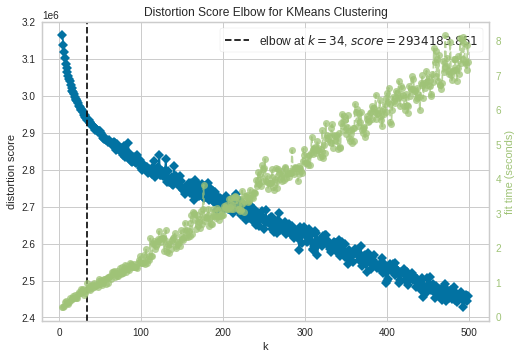

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [13]:
#@title Distortion should go down.
model = KMeans()
visualizer = KElbowVisualizer(model, k=(4,500))
visualizer.fit(year_vectors)                                                    # Fit the data to the visualizer
visualizer.poof()

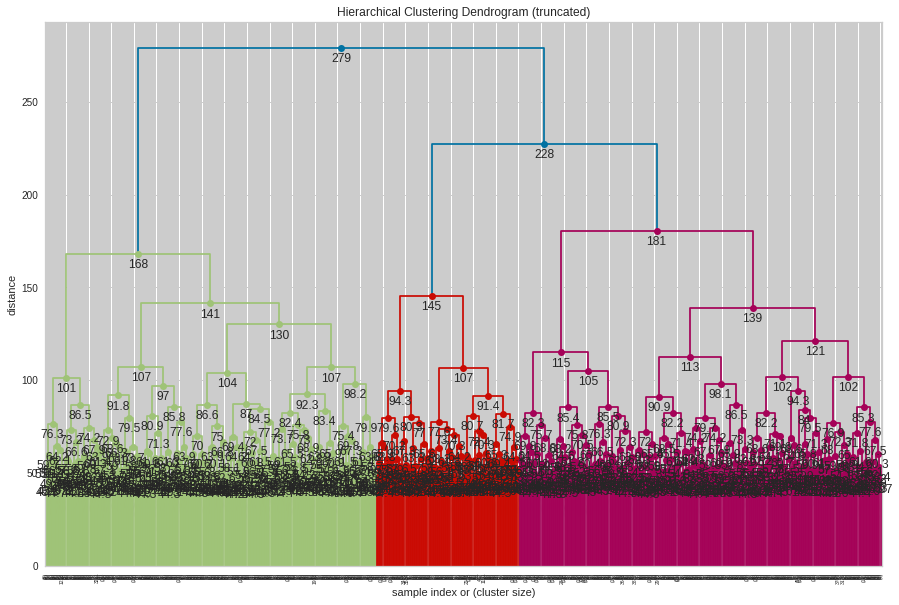

In [9]:
#@title Dendrogram choose either single OR average OR ward
print(period)
dendrogram = aa.fancy_dendrogram(sch.linkage(year_vectors, method='ward'),
            truncate_mode='lastp',p=800,show_contracted=True,figsize=(15,10)) 

#### Init clustering

In [ ]:
n_clusters = 13
top_labeles_to_draw = 5
chance_of_printing_label = 0.3
comment = ''
dim = '100D 4k'

#### Cluster

In [ ]:
model = AgglomerativeClustering(n_clusters=n_clusters,linkage='ward').fit(year_vectors)
labels = model.labels_

In [ ]:
clusters_df = pd.DataFrame({'sources':year_sources,'clusters':labels})
clusters_df.to_csv(datapath+'Document Clustering/'+dim+'/agglomerative ward '+period+' '+str(n_clusters)+'.csv',index=False)

In [ ]:
clusters_df = pd.DataFrame({'topic':year_topics_sep_joined,'clusters':labels})
clusters_df.to_csv(datapath+'Document Clustering/'+dim+'/agglomerative ward '+period+' '+str(n_clusters)+' - topic_labels.csv',index=False)

In [ ]:
plus = ''
# plus = ' -plus'
clusters_df = pd.DataFrame({'topic':year_keywords_sep_joined,'clusters':labels})
clusters_df.to_csv(datapath+'Document Clustering/'+dim+'/agglomerative ward '+period+' '+str(n_clusters)+plus+' - keyword_labels.csv',index=False)

In [ ]:
# Abstracts
# file_address = datapath+'Corpus/AI 4k/copyr_deflem_stopword_removed_thesaurus May 28/by period/n-gram by 6 repetition keywords/'+period+' abstract_title'

year_abstracts = pd.read_csv(file_address,names=['abstract'])['abstract'].values
clusters_df = pd.DataFrame({'topic':year_abstracts,'clusters':labels})
clusters_df.to_csv(datapath+'Document Clustering/'+dim+'/agglomerative ward '+period+' '+str(n_clusters)+' - abstract_labels.csv',index=False)

In [8]:
# read abstract clusters instead of doing a fresh clustering
cluster_file_name = datapath+"Corpus/AI 4k/embeddings/clustering/k10/Doc2Vec patent_wos_ai corpus DEC 200,500,10 k10 labels"
clusters_df = pd.read_csv(cluster_file_name)

##### TF-IDF labels

In [6]:
def get_abstract_keywords(corpus,keywords_wanted,max_df=0.9,max_features=None):
    cv=CountVectorizer(max_df=max_df,stop_words=stop_words, max_features=max_features, ngram_range=(1,1))
    X=cv.fit_transform(corpus)
    # get feature names
    feature_names=cv.get_feature_names()
    tfidf_transformer=TfidfTransformer(smooth_idf=True,use_idf=True)
    tfidf_transformer.fit(X)
    keywords_tfidf = []
    keywords_sorted = []
    for doc in tqdm(corpus,total=len(corpus)):
        tf_idf_vector=tfidf_transformer.transform(cv.transform([doc]))
        sorted_items=kw.sort_coo(tf_idf_vector.tocoo())
        keywords_sorted.append(sorted_items)
        keywords_tfidf.append(kw.extract_topn_from_vector(feature_names,sorted_items,keywords_wanted))
    return keywords_tfidf

def get_corpus_top_keywords(abstract_keywords_dict=None):
    if abstract_keywords_dict == None:
        print("keywords should be provided")
        return False
    terms = []
    values = []
    for doc in abstract_keywords_dict:
        if doc != None:
            terms = terms+list(doc.keys())
            values = values+list(doc.values())
    terms_df = pd.DataFrame({'terms':terms,'value':values}).groupby('terms').sum().sort_values('value',ascending=False)
    return terms_df

def find_max_item_value_in_all_cluster(haystack,needle,cluster_exception=None):
    max_val = 0
    max_index = None
    counter = 0
    for item in haystack:
        try:
            if item[needle]>max_val:
                if cluster_exception==None:
                    max_val = item[needle]
                    max_index = counter
                else:
                    if cluster_exception != counter:
                        max_val = item[needle] 
                        max_index = counter
        except:
            pass
        counter+=1

        if max_index!=None:
            row_max = haystack[max_index][list(haystack[max_index].keys())[0]] # Will give the maximum value (first item) of the row with max value of the needle. This gives us a perspective to see how this score compares to the max in the same row.
        else:
            row_max = 0
    # except:
        # row_max = None
    

    return max_val,row_max

##### Regular TF-IDF labels

In [ ]:
# TF-IDF (normal)
year_tfidf_keywords_sep_joined = []
year_tfidf_labels = []
year_abstracts = pd.read_csv(datapath+"Corpus/copyr_lemmatized_stopword_removed_thesaurus/by period/n-gram by 2 repetition keywords/"+period+" abstract_title",names=['abstract'])['abstract']
cluster_groups = clusters_df.groupby('label').groups
for cluster in cluster_groups.keys():
    cluster_abst_ids = list(cluster_groups[cluster])
    cluster_abstracts = year_abstracts[cluster_abst_ids].values
    cluster_keywords_tfidf = get_abstract_keywords(cluster_abstracts,10,max_df=0.5)
    cluster_top_words = list(get_corpus_top_keywords(cluster_keywords_tfidf).index[:6])
    year_tfidf_labels.append(get_corpus_top_keywords(cluster_keywords_tfidf).head(6).reset_index().values.tolist())
    year_tfidf_keywords_sep_joined.append(';'.join(cluster_top_words))
    # print('\n',cluster_top_words_joined)
year_tfidf_keywords_sep_joined
pd.DataFrame(year_tfidf_labels).to_csv(datapath+"Document Clustering/"+dim+"/labels/agglomerative ward "+period+" "+str(n_clusters)+" - TF-IDF_labels.csv",index=False,header=False)

##### CTF-ICF labels

In [11]:
# TF-IDF (CTF-ICF)
cluster_as_string = []
year_abstracts = pd.read_csv(file_address,names=['abstract'])['abstract']
clusters = clusters_df.groupby('label').groups
for key in clusters.keys():
    cluster_as_string.append(' '.join(year_abstracts[list(clusters[key])]))
cluster_keywords_tfidf = get_abstract_keywords(cluster_as_string,100,max_df=0.8)

cluster_keywords = []
cluster_index = 0
for items in cluster_keywords_tfidf:
    items_tmp = []
    for item in items:
        max_data = find_max_item_value_in_all_cluster(cluster_keywords_tfidf,item,cluster_index)
        items_tmp.append(item+' ('+str(items[item])+' | '+str(max_data[0])+'/'+str(max_data[1])+')') # (item+' :'+str(items[item])+' / '+str( max of item in all other rows))
    cluster_keywords.append(items_tmp)
    cluster_index+=1
pd.DataFrame(cluster_keywords).to_csv(cluster_file_name+" keywords",index=False,header=False)

100%|██████████| 10/10 [00:00<00:00, 44.14it/s]


In [12]:
# Get term cluster labels (just terms and not scores)
cluster_keywords_terms = []
cluster_keywords_scores = []
for item in cluster_keywords_tfidf:
    cluster_keywords_terms.append(list(item.keys()))
    cluster_keywords_scores.append(list(item.values()))

pd.DataFrame(cluster_keywords_terms).T.to_csv(cluster_file_name+" keywords - term_cluster.csv",index=False)
pd.DataFrame(cluster_keywords_scores).T.to_csv(cluster_file_name+" keywords - term_score.csv",index=False)

In [ ]:
# Get term frequencies for each period
terms = ' '.join(cluster_as_string).split()
terms = [x for x in terms if x not in list(stop_words)]
pd.DataFrame(terms,columns=['terms'])['terms'].value_counts().to_csv(datapath+'Corpus/AI 4k/copyr_deflem_stopword_removed_thesaurus May 28/by period/n-gram by 6 repetition keywords/'+period,header=False)

##### Word centrality labels

In [ ]:
sub_dim = ''
# dim = '50'
dim_comment = ''
period = '2014-2016' 
n_clusters = 11

# read abstract clusters instead of doing a fresh clustering
cluster_file_name = datapath+'Document Clustering/'+dim+'/agglomerative ward '+period+' '+str(n_clusters)+' - abstract_labels.csv' 
clusters_df = pd.read_csv(cluster_file_name)

In [ ]:
def embed(word,model,sep):
    phrase=word.split(sep)
    gram_vecs = []
    for gram in phrase:
        gram_vecs.append(model.wv[gram])
    return np.array(gram_vecs).mean(axis=0)

gensim_model_address = datapath+'FastText Models/50D May 16/fasttext-scopus-300k_docs-gensim 50D.model'
FT_model = fasttext_gensim.load(gensim_model_address)

In [ ]:
# Read cluster center
center_address = datapath+'Document Clustering/'+dim+'/'+sub_dim+'centers/agglomerative ward '+period+' '+str(n_clusters)+comment
cluster_centers = pd.read_csv(center_address,index_col=0)

In [ ]:
term_scores = []
for cluster_n in range(n_clusters-1):
    cluster_center = cluster_centers.iloc[cluster_n].values
    cluster_abstrcts = clusters_df[clusters_df['clusters']==cluster_n].copy()
    cluster_abstrcts = cluster_abstrcts['topic'].str.lower().values.tolist()
    cluster_abstrcts = ' '.join(cluster_abstrcts)
    cluster_terms = cluster_abstrcts.split()
    cluster_terms = pd.DataFrame(cluster_terms)
    cluster_terms.columns = ['terms']
    cluster_terms_tmp = list(cluster_terms.groupby('terms').groups.keys())
    cluster_terms = pd.DataFrame([])
    cluster_terms['terms'] = cluster_terms_tmp

    x = [embed(word,FT_model,'_') for word in cluster_terms.terms.values.tolist()]
    
    cluster_terms['vectors'] = x
    cluster_terms['similarity'] = [1-spatial.distance.cosine(vector, cluster_center) for vector in np.array(cluster_terms['vectors'])]
    cluster_terms = cluster_terms.sort_values(by=['similarity'],ascending=False)

    cluster_terms = cluster_terms[['terms','similarity']]
    term_scores.append(cluster_terms.set_index('terms').T.to_dict('records'))

    # top_words = cluster_terms.head(1000)['terms'].values.tolist()
    # top_scores = cluster_terms.head(1000)['similarity'].values.tolist()

###### Combine CTF-ICF and Cluster centrality

In [ ]:
cluster_as_string = []
year_abstracts = clusters_df['topic'].values
clusters = clusters_df.groupby('clusters').groups
for key in clusters.keys():
    cluster_as_string.append(' '.join(year_abstracts[list(clusters[key])]))
cluster_keywords_tfidf = get_abstract_keywords(cluster_as_string,1000,max_df=0.8)

new_scores = []
for cluster_n in range(n_clusters-1):
    terms = list(cluster_keywords_tfidf[cluster_n].keys())
    scores = [cluster_keywords_tfidf[cluster_n][term]*term_scores[cluster_n][0][term] for term in terms]
    new_data = dict(zip(terms, scores))
    new_scores.append(new_data)

In [ ]:
saving_path = datapath+"Document Clustering/"+dim+"/labels/agglomerative ward "+period+" "+str(n_clusters)+" - central_tficf labels_withmax.csv"


cluster_keywords = []
cluster_index = 0
for items in cluster_keywords_tfidf:
    items_tmp = []
    for item in items:
        max_data = find_max_item_value_in_all_cluster(cluster_keywords_tfidf,item,cluster_index)
        items_tmp.append(item+' ('+str(items[item])+' | '+str(max_data[0])+'/'+str(max_data[1])+')') # (item+' :'+str(items[item])+' / '+str( max of item in all other rows))
    cluster_keywords.append(items_tmp)
    cluster_index+=1
print('saving to ',saving_path)
pd.DataFrame(cluster_keywords).to_csv(saving_path,index=False,header=False)

#### Visualize clusters - with source labels

In [ ]:
cluster_file_name = datapath+'FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+'.csv'
cluster_file_name

In [ ]:
clusters_df = pd.read_csv(cluster_file_name)
clusters_df = clusters_df[clusters_df['sources'].isin(year_sources)]
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors

In [ ]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

##### Visualize clusters - with sources as labels

In [ ]:
whitelist = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get sources for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Group sources to get unique source names and sort them by frequency
    source_counts = this_cluster_df.groupby('sources').count()['clusters'].reset_index().sort_values(by=['clusters'], ascending=False)
    source_counts.columns = ['sources','frequency']
    # Get top N sources by frequency
    whitelist = whitelist + source_counts['sources'].head(top_labeles_to_draw).values.tolist()

fig, ax = plt.subplots(figsize=(25, 18), dpi=150)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, label in enumerate(year_sources):
    if label in whitelist:
        if len(label)>20:
            year_sources_orig.append(label)
            label = aa.abbreviator(label)
            year_sources_abbr.append(label)

        ax.annotate(label, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels.jpg')

In [ ]:
year_sources_abbr = pd.DataFrame(year_sources_abbr)
year_sources_abbr['original'] = year_sources_orig
year_sources_abbr.columns = ['abbreviation','original']
year_sources_abbr.to_csv(cluster_file_name[:-4]+' - labels guide.csv')
year_sources_abbr

#### Visualize clusters - with topic labels

In [ ]:
cluster_file_name = datapath+'FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+' - topic_labels.csv'
cluster_file_name

In [ ]:
clusters_df = pd.read_csv(cluster_file_name)
# clusters_df = clusters_df[clusters_df['topic']!='*']
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors


In [ ]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

In [ ]:
whitelist = []
topic_terms = []
topic_frequencies = []
for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get indices for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Flatten topics of cluster
    cluster_topics = [x.split(';') for x in this_cluster_df['topic'].to_list()]
    topics = pd.DataFrame([j for sub in cluster_topics for j in sub])
    topics.columns = ['topic']
    # Group topics to get unique source names and sort them by frequency
    g_tmp = pd.DataFrame(topics['topic'].value_counts()).reset_index()
    g_tmp.columns = ['topic','count']
    g_tmp = g_tmp.sort_values(by=['count'], ascending=False)
    # Get top N sources by frequency
    whitelist = whitelist + g_tmp['topic'].head(top_labeles_to_draw).values.tolist()
    tmp_terms = []
    tmp_freqs = []
    for i,x in enumerate(g_tmp['topic'].tolist()):
        if x!='':
            tmp_terms.append(x)
            tmp_freqs.append(g_tmp['count'].tolist()[i])
    if idx == 0:
        top_topic = g_tmp.head(15).copy()
    else:
        top_topic = pd.concat([top_topic, g_tmp.head(15)], axis=1)
    topic_terms.append(tmp_terms)
    topic_frequencies.append(tmp_freqs)

whitelist = [element for element in whitelist if element!='computer science']
# top_topic

In [ ]:
top_topic.to_csv(cluster_file_name[:-4]+' - topic cluster frequency.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=200)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, topics_joined in enumerate(year_topics_sep_joined):
    if any(element in whitelist for element in topics_joined.split(';')):
        if random()<=chance_of_printing_label:
            ax.annotate(topics_joined, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels - topic labels.jpg')

#### Visualize clusters - with keyword labels

In [ ]:
plus = ''
# plus = ' -plus'
cluster_file_name = datapath+'FastText doc clusters - SIP/'+dim+'D/agglomerative ward '+period+' '+str(n_clusters)+plus+' - keyword_labels.csv'
cluster_file_name

In [ ]:
clusters_df = pd.read_csv(cluster_file_name)
# clusters_df = clusters_df[clusters_df['topic']!='*']
color_palette = aa.color_palette_maker(n_clusters)
colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
clusters_df['colors'] = colors

In [ ]:
pca = PCA(2)
pca.fit(year_vectors)
#pca.n_components_
vector_low_dim = pca.transform(year_vectors)
vector_low_dim[:,1].shape

In [ ]:
whitelist = []
keywords_terms = []
keywords_frequencies = []

clusters_df['topic'] = clusters_df['topic'].fillna('')

for idx in range(len(clusters_df.groupby('clusters').groups)):
    # Get indices for this cluster
    this_cluster_df = clusters_df.iloc[list(clusters_df.groupby('clusters').groups[idx])]
    # Flatten topics of cluster
    cluster_topics = [x.split(';') for x in this_cluster_df['topic'].to_list()]
    topics = pd.DataFrame([j for sub in cluster_topics for j in sub])
    topics.columns = ['topic']
    # Group topics to get unique source names and sort them by frequency
    g_tmp = pd.DataFrame(topics['topic'].value_counts()).reset_index()
    g_tmp.columns = ['topic','count']
    g_tmp = g_tmp.sort_values(by=['count'], ascending=False)
    # Get top N sources by frequency
    whitelist = whitelist + g_tmp['topic'].head(top_labeles_to_draw).values.tolist()
    tmp_terms = []
    tmp_freqs = []
    for i,x in enumerate(g_tmp['topic'].tolist()):
        if x!='':
            tmp_terms.append(x)
            tmp_freqs.append(g_tmp['count'].tolist()[i])
    if idx == 0:
        top_topic = g_tmp.head(15).copy()
    else:
        top_topic = pd.concat([top_topic, g_tmp.head(15)], axis=1)
    keywords_terms.append(tmp_terms)
    keywords_frequencies.append(tmp_freqs)
    
whitelist = [element for element in whitelist if element!='']
# top_topic

In [ ]:
top_topic.to_csv(cluster_file_name[:-4]+' - keyword cluster frequency.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20), dpi=200)
ax.scatter(vector_low_dim[:,0], vector_low_dim[:,1],color = colors)
year_sources_abbr = []
year_sources_orig = []
for i, topics_joined in enumerate(year_keywords_sep_joined):
    if any(element in whitelist for element in topics_joined.split(';')):
        if random()<=chance_of_printing_label:
            ax.annotate(topics_joined, (vector_low_dim[i,0], vector_low_dim[i,1]), fontsize=8, fontweight='ultralight')

fig.savefig(cluster_file_name[:-4]+' - reduced labels - keyword labels.jpg')

### Cluster Center Calc

In [ ]:
sub_dim = ''
# dim = '50'
dim_comment = ''

# period = '1990-2004' 
#@markdown Period should be set at vector year preparation section!!
comment = ''
use_current_cluster_file_name = True #@param {type:"boolean"}
use_current_cluster_numbers = True #@param {type:"boolean"}

if use_current_cluster_file_name is False:
    print('Using custom cluster file name...')
    cluster_file_name = ''#@param {type:"string"}
    if use_current_cluster_numbers is False: 
        n_clusters_new = 6#@param {type:"number"} 
    else:
        n_clusters_new == n_clusters
    if cluster_file_name == '':
        print('Custom cluster file name not provided! Trying to get the default location...')
        cluster_file_name = datapath+'FastText doc clusters - SIP/'+dim+'/'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters_new)+comment

clusters_df = pd.read_csv(cluster_file_name)
vectors_df = pd.DataFrame(year_vectors)
    
# color_palette = aa.color_palette_maker(n_clusters_new)
# colors = aa.cluster_color_mapper(clusters_df['clusters'].values.tolist(),color_palette)
# clusters_df['colors'] = colors
if(clusters_df.shape[0] != vectors_df.shape[0]):
    print('Fix year vector section. periods here should be set from that section.')
else:
    print('Shapes:',clusters_df.shape[0],'matche. Good to go!')


In [ ]:
print(cluster_file_name)

In [ ]:
# n_clusters = n_clusters_new
cluster_centers = []
for cluster in tqdm(range(n_clusters),total=n_clusters):
    cluster_centers.append(vectors_df.iloc[clusters_df[clusters_df['clusters']==cluster].index].mean(axis=0))

In [ ]:
pd.DataFrame(cluster_centers).to_csv(datapath+'Document Clustering/'+dim+'/'+sub_dim+'centers/agglomerative ward '+period+' '+str(n_clusters)+comment)

In [ ]:
!ls 'drive/My Drive/Data/Document Clustering/50D 4k/centers/' 

### Cluster Similarity Calc

In [ ]:
sub_dim = ''#@param {type:"string"} 
dim = '50'#@param {type:"string"} 
dim_comment = ' 4k'#@param {type:"string"} 
comment = ''#@param {type:"string"} 

period_A = '1990-2004'#@param {type:"string"} 
n_clusters_A = 10#@param {type:"number"} 

period_B = '2005-2007'#@param {type:"string"} 
n_clusters_B = 8#@param {type:"number"} 

clusters_A = pd.read_csv(datapath+'Document Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/agglomerative ward '+period_A+' '+str(n_clusters_A)+comment,index_col=0)
clusters_B = pd.read_csv(datapath+'Document Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'centers/agglomerative ward '+period_B+' '+str(n_clusters_B)+comment,index_col=0)


In [ ]:
names = []
names.append('cluster_1')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        distance_tmp = spatial.distance.cosine(vector_A.values, vector_B.values)
        similarity_tmp = 1 - distance_tmp

        inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            names.append('cluster_2_'+str(idx_B))
            names.append('similarity_'+str(idx_B))

    sim_A_to_B.append(inner_similarity_scores)
    print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv(datapath+'Document Clustering/'+dim+'D'+dim_comment+'/'+sub_dim+'similarity/agglomerative ward '+period_A+'_'+str(n_clusters_A)+'-'+period_B+'_'+str(n_clusters_B)+'.csv',index=False)

### Cluster Classification similarity calc

In [ ]:
classification_type = "applications" #@param {type:"string"}
classification_type_dir =  "application" #@param {type:"string"}
sub_dim = ''
dim = '50D 4k'#@param {type:"string"}
dim_comment = ''
comment = ''#@param {type:"string"}

period_A = '2017-2019'#@param {type:"string"} 
n_clusters_A = 11#@param {type:"number"} 

clusters_A = pd.read_csv(datapath+'Document Clustering/'+dim+'/'+sub_dim+'centers/agglomerative ward '+period_A+' '+str(n_clusters_A)+comment,index_col=0)
clusters_B = pd.read_csv(datapath+'Corpus/AI Wiki Classifications/'+classification_type+'/clean/vectors/all')
clusters_B_labels = pd.DataFrame(clusters_B.clusters.values.tolist(),columns=['label'])
clusters_B = clusters_B.drop(['clusters'],axis=1)

In [ ]:
names = []
names.append('clusters')
sim_A_to_B = []
for idx_A,vector_A in clusters_A.iterrows():
    inner_similarity_scores = []
    inner_similarity_scores.append(idx_A)
    for idx_B,vector_B in clusters_B.iterrows():
        distance_tmp = spatial.distance.cosine(vector_A.values, vector_B.values)
        similarity_tmp = 1 - distance_tmp

        # inner_similarity_scores.append(idx_B)
        inner_similarity_scores.append(similarity_tmp)

        if idx_A == 0:
            # names.append('classification_'+str(idx_B))
            # names.append('similarity_'+str(idx_B))
            names.append(clusters_B_labels['label'][idx_B])

    sim_A_to_B.append(inner_similarity_scores)
        # print('cluster of A:',idx_A,'to cluster of B:',idx_B,'similarity',similarity_tmp)

sim_A_to_B = pd.DataFrame(sim_A_to_B,columns=names)
sim_A_to_B.to_csv(datapath+'Document Clustering/'+dim+'/'+sub_dim+classification_type_dir+' estimation/'+period_A+'_'+str(n_clusters_A)+' - AI Wiki Classifications.csv',index=False)

##### Classification similarity labeling

In [ ]:
# classification_type = "application" #@param {type:"string"}
# dim = '50D May 23'#@param {type:"string"}
# sub_dim = ''
# period_A = '1990-2018'#@param {type:"string"}
# n_clusters_A = '12'#@param {type:"string"}
similarity = pd.read_csv(datapath+'Document Clustering/'+dim+'/'+sub_dim+classification_type_dir+' estimation/'+period_A+'_'+str(n_clusters_A)+' - AI Wiki Classifications.csv')
similarity = similarity.drop(['clusters'],axis=1)


In [ ]:
top_2 = pd.DataFrame(similarity.apply(lambda s: s.abs().nlargest(2).index.tolist(), axis=1))
top_2.columns = ['label']
top_2['label'] = top_2['label'].apply(lambda x: x[0]+' & '+x[1])
top_2.to_csv(datapath+'Document Clustering/'+dim+'/'+sub_dim+classification_type_dir+' estimation/top2 '+period_A+'_'+str(n_clusters_A)+'- AI Wiki Classifications.csv')

### Term-cluster tables

#### Term-cluster tables: TFIDF words

* For word tables by TFIDF go up to the corresponding section.

#### Term-cluster tables: sources

In [ ]:
sub_dim = ''#@param {type:"string"} 
dim_comment = ' w2'#@param {type:"string"} 
dim = '50'#@param {type:"string"} 
n_clusters = 7#@param {type:"number"} 
comment = ''#@param {type:"string"} 
save_frequency_to_disk = False #@param {type:"boolean"}

cluster_file_name = datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'agglomerative ward '+period+' '+str(n_clusters)+comment
clusters = pd.read_csv(cluster_file_name+'.csv')
term_table = clusters.groupby('clusters').groups

year_sources_df = pd.DataFrame(year_sources)
year_sources_df['clusters'] = clusters['clusters']
year_sources_df.columns = ['sources','clusters']
year_sources_df = year_sources_df.groupby('sources').count()['clusters'].reset_index().sort_values(by=['clusters'], ascending=False)
year_abbreviations = []

for item in tqdm(year_sources_df['sources'],total=year_sources_df.shape[0]):
    year_abbreviations.append(aa.abbreviator(item))

year_sources_df.columns = ['sources','frequency']
year_sources_df['sources_abbr'] = year_abbreviations

if save_frequency_to_disk is True:
    save_dest_address = datapath+'corpus/improved_copyr_lemmatized_stopwords_removed_thesaurus_n-grams/source_frequency_abbr.csv'#@param {type:"string"}
    year_sources_df.to_csv(save_dest_address,index=False)

In [ ]:
# term_table_df = pd.DataFrame([list(clusters['terms'][term_table[x]]) for x in term_table]).T.fillna('')
# score_table_df = [list(corpus[corpus['keyword']==clusters['terms'][term_table[x]]]['frequency']) for x in term_table]

# groups.to_csv('drive/My Drive/Data/FastText authkeyword clusters - 29 Oct 2019/'+dim+'D/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment,index=False)

term_table_df = []
score_table_df = []
for cluster_items in tqdm(term_table,total=len(term_table)):
    cluster_terms = list(clusters['sources'][term_table[cluster_items]])
    cluster_scores = [year_sources_df[year_sources_df['sources']==x]['frequency'].values[0] for x in cluster_terms]
    score_table_df.append(cluster_scores)
    term_table_df.append(cluster_terms)
comment = ' - term_cluster'
term_table_df = pd.DataFrame(term_table_df).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
score_table_df = pd.DataFrame(score_table_df).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)


#### Term-cluster tables: keywords

In [ ]:
sub_dir = 'authkeyword/'
# sub_dir = 'keywordplus'
comment = ' - term_cluster'
dim_comment = ''
sub_dim = ''
pd.DataFrame(keywords_terms).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
pd.DataFrame(keywords_frequencies).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)

#### Term-cluster tables: topics

In [ ]:
sub_dir = 'topics/'
comment = ' - term_cluster'
dim_comment = ''
sub_dim = ''
pd.DataFrame(topic_terms).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)
comment = ' - term_score'
pd.DataFrame(topic_frequencies).T.to_csv(datapath+'FastText doc clusters - SIP/'+dim+'D'+dim_comment+'/'+sub_dim+'term_cluster-tables/'+sub_dir+'_agglomerative ward '+period+' '+str(n_clusters)+comment+'.csv',index=False)

### Write document meta, cluster and vector to disk




> Must run:
> 
> 
> 1.   Load vectors (option B)
> 2.   Vector preparation and year selection
> 3.   Clustering initialization
> 4.   Clustering (only the first one to get labels)
> 5.   Visualization first block to get the correct cluster_file_name
> 6.   Cluster center calc (except the last block. no need to wirte to disk again)
> 7.   All blocks below







In [ ]:
year_meta_df = pd.DataFrame(year_meta).reset_index(drop=True)
year_meta_df.columns = ['title','abstract','year','citations','usages','publication_name','iso_name','author_keywords','keywords_plus','wos_categories','research_area']
year_meta_df.shape

In [ ]:
year_vectors_np = np.array(year_vectors)
year_vectors_df = pd.DataFrame(year_vectors_np)
year_vectors_df.shape

In [ ]:
# Distance from center
similarities = []
for idx,doc_vec in tqdm(enumerate(year_vectors_np),total=year_vectors_np.shape[0]):
    distance_tmp = spatial.distance.cosine(doc_vec, cluster_centers[labels[idx]].values)
    similarity_tmp = 1 - distance_tmp
    similarities.append(similarity_tmp)

In [ ]:
year_vectors_df['origingal_doc_index'] = year_index
year_vectors_df = pd.concat([year_vectors_df, year_meta_df], axis = 1)
year_vectors_df['cluster_label'] = labels
year_vectors_df['similarity_to_center'] = similarities

In [ ]:
# Write
year_vectors_df.to_csv(datapath+'FastText doc clusters - SIP/50D/vectors and metadata/'+period+' year_doc_vector.csv',index=False)
period

In [ ]:
year_vectors_df[['origingal_doc_index','abstract']]

### Term Frequency Calc

In [ ]:
# Load dataset with processed abstracts
abstracts = []
abstract_corpus = pd.read_csv(datapath+'corpus/improved_copyr_abstract-sentences_cumulative/1990-2018  meta and data.csv')
abstract_corpus = abstract_corpus['processed_abstracts'].reset_index()
abstract_corpus.loc[25506]
# merged_left = pd.merge(left=year_vectors_df,right=abstract_corpus, how='left', left_on='origingal_doc_index', right_on='index')
# merged_left